# Example of field-free orientation of $\text{NH}_3$ (rigid) molecule using two-colour field.

Two-colour field:
$$
E(t) = E_0 e^{-4\log 2\frac{(t-t_0)^2}{\tau^2}}\left(\cos(\omega_1t)+\cos(\omega_2t)\right)
$$

Molecule-field interaction potential (assuming for high $\omega_1$ and $\omega_2$, contribution from the dipole moment averages out to zero):
$$
V(t)=-\frac{1}{2}\sum_{A,B=X,Y,Z}\alpha_{AB}E_A(t)E_B(t) - \frac{1}{6}\sum_{A,B,C=X,Y,Z}\beta_{ABC}E_A(t)E_B(t)E_C(t)
$$

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants

from richmol import (
    HYPERPOL_X_FIELD3_INVCM,
    POL_X_FIELD2_INVCM,
    CartTensor,
    RotStates,
    propagate_expokit,
)
from richmol.asymtop import write_xyz

Define molecular parameters.

In [ ]:
atom_labels = ["N", "H", "H", "H"]

# Cartesian coordinates of atoms in NH3 (Angstrom)

atom_xyz = (
    np.array(
        [
            [0.0000000000, 0.0000000000, -0.0960518058],
            [1.5509874272, -0.8954630086, 0.4448591586],
            [-1.5509874272, -0.8954630086, 0.4448591586],
            [0.0000000000, 1.7909260172, 0.4448591586],
        ]
    )
    * constants.value("Bohr radius")
    * 1e10
)

write_xyz("nh3.xyz", atom_labels, atom_xyz)

# dipole moment, polarizability, and hyperpolarizability (a.u.),
#   calculated using CCSD/aug-cc-pVTZ in Dalton

dip_mol = np.array([0.0, 0.0, 0.4867])

pol_mol = np.array(
    [13.1404, 0.0, 0.0, 0.0, 13.1404, 0.0, 0.0, 0.0, 15.1515]
).reshape(3, 3)

hyperpol_mol = np.array(
    [
        0.0,
        12.2422,
        -5.2379,
        12.2422,
        0.0,
        0.0,
        -5.2379,
        0.0,
        0.0,
        12.2422,
        0.0,
        0.0,
        0.0,
        -12.2422,
        -5.2379,
        0.0,
        -5.2379,
        0.0,
        -5.2379,
        0.0,
        0.0,
        0.0,
        -5.2379,
        0.0,
        0.0,
        0.0,
        -27.9005,
    ]
).reshape(3, 3, 3)

Solve rotational problem in rigid-rotor approximation and compute rotational matrix elements of laboratory-frame electric field tensors.

In [4]:
# Compute rotational states and matrix elements of laboratory-frame tensors

xyz = [[atom, *xyz] for atom, xyz in zip(atom_labels, atom_xyz)]
xyz = [el for elem in xyz for el in elem]

jmax = 10
states = RotStates.from_geometry(
    jmax,
    xyz,
    print_enr=True,
)

dip_lab = CartTensor(states, dip_mol)
pol_lab = CartTensor(states, pol_mol)
hyperpol_lab = CartTensor(states, hyperpol_mol)

cos_beta = CartTensor(states, "cos(beta)")
cos2_beta = CartTensor(states, "cos^2(beta)")


Compute rigid-rotor solutions using molecular geometry as input
Cartesian units: angstrom, conversion to Angstrom: 1
  Atom           Mass (u)              X (Å)              Y (Å)              Z (Å)
     N    14.003074004250     0.000000000000     0.000000000000    -0.050828426661
     H     1.007825031898     0.820747200315    -0.473858617036     0.235409328633
     H     1.007825031898    -0.820747200315    -0.473858617036     0.235409328633
     H     1.007825031898     0.000000000000     0.947717234073     0.235409328633
G-matrix from input Cartesian coordinates (cm^-1):
 [[ 2.15912361e+01  3.01647219e-16  4.97680323e-17]
 [-3.01647219e-16  2.15912361e+01  1.28561269e-15]
 [-8.65496740e-17 -2.39710874e-15  1.24154521e+01]]
solve for J = 0 and symmetry A ...
number of functions: 1
solve for J = 1 and symmetry A ...
number of functions: 3
solve for J = 2 and symmetry A ...
number of functions: 5
solve for J = 3 and symmetry A ...
number of functions: 7
solve for J = 4 and symmetry 

Define two-colour field.

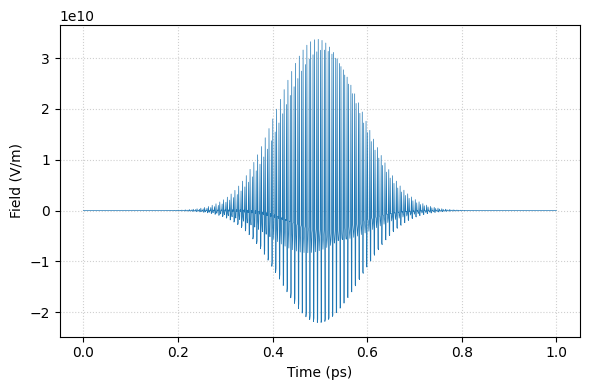

In [16]:
def field_z(time, fwhm, t0=None):
    nm = 1e-9
    omega1 = 800 * nm  # in nm
    omega2 = 400 * nm  # in nm
    omega1 = 2 * np.pi * constants.speed_of_light / omega1 * 1e-12  # in 1/ps
    omega2 = 2 * np.pi * constants.speed_of_light / omega2 * 1e-12  # in 1/ps
    if t0 is None:
        t0 = 2.5 * fwhm / 2
    amp = 2e10  # in V/m
    return (
        amp * np.exp(-4 * np.log(2) * (time - t0) ** 2 / fwhm**2) * (np.cos(omega1 * time)+np.cos(omega2*time))
    )


plt.figure(figsize=(6, 4), dpi=100)

t = np.linspace(0, 1, 1000)
plt.plot(t, field_z(t, fwhm=0.2, t0=0.5), linewidth=0.5)
plt.xlabel("Time (ps)")
plt.ylabel("Field (V/m)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.yticks(fontsize=10)
plt.tight_layout()

Solve TDSE for rotations in field, from the initial state $|J,k,\tau\rangle=|0,0,0\rangle$. Molecule-field interaction is modelled by polarizability and hyperpolarizability coupling terms.

In [ ]:
# initial wavepacket: J,k,tau=0,0,0 (ground) state
c0 = np.zeros(states.mat().shape[0], dtype=np.complex128)
c0[0] = 1.0

field_au = constants.value("atomic unit of electric field")
field_func = lambda t: np.array([0, 0, field_z(t, fwhm=0.2, t0=0.5) / field_au])

time, c_t = propagate_expokit(
    states,
    [pol_lab, hyperpol_lab],
    [-1 / 2 * POL_X_FIELD2_INVCM, -1 / 6 * HYPERPOL_X_FIELD3_INVCM],
    field_func=field_func,
    t0=0,
    t1=10,
    dt=0.001,
    time_unit="ps",
    c0=c0,
)

Plot rotational state populations.

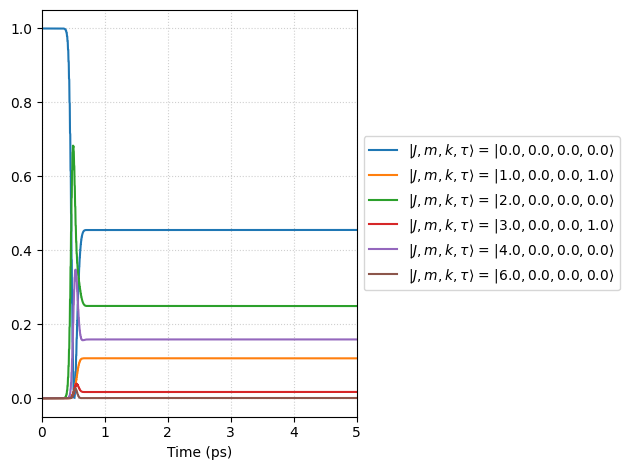

In [10]:
# state populations
pop_t = np.abs(c_t) ** 2

# states with nonzero populations
state_ind = np.any(np.abs(pop_t) > 1e-2, axis=0).nonzero()[0]
state_qua = [
    f"$|J,m,k,\\tau\\rangle$ = $|{j}, {m}, {k}, {tau}\\rangle$"
    for (j, m, k, tau, *_) in states.quanta[state_ind]
]

plt.plot(time, pop_t[:, state_ind], label=state_qua)
plt.xlim([0, 5])

plt.xlabel("Time (ps)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, loc="center left", bbox_to_anchor=(1, 0.5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Compute and plot alignment functions $\cos\beta$ and $\cos^2\beta$ ($\beta$ is the Euler angle between the molecular $z$ and the laboratory $Z$ axes).

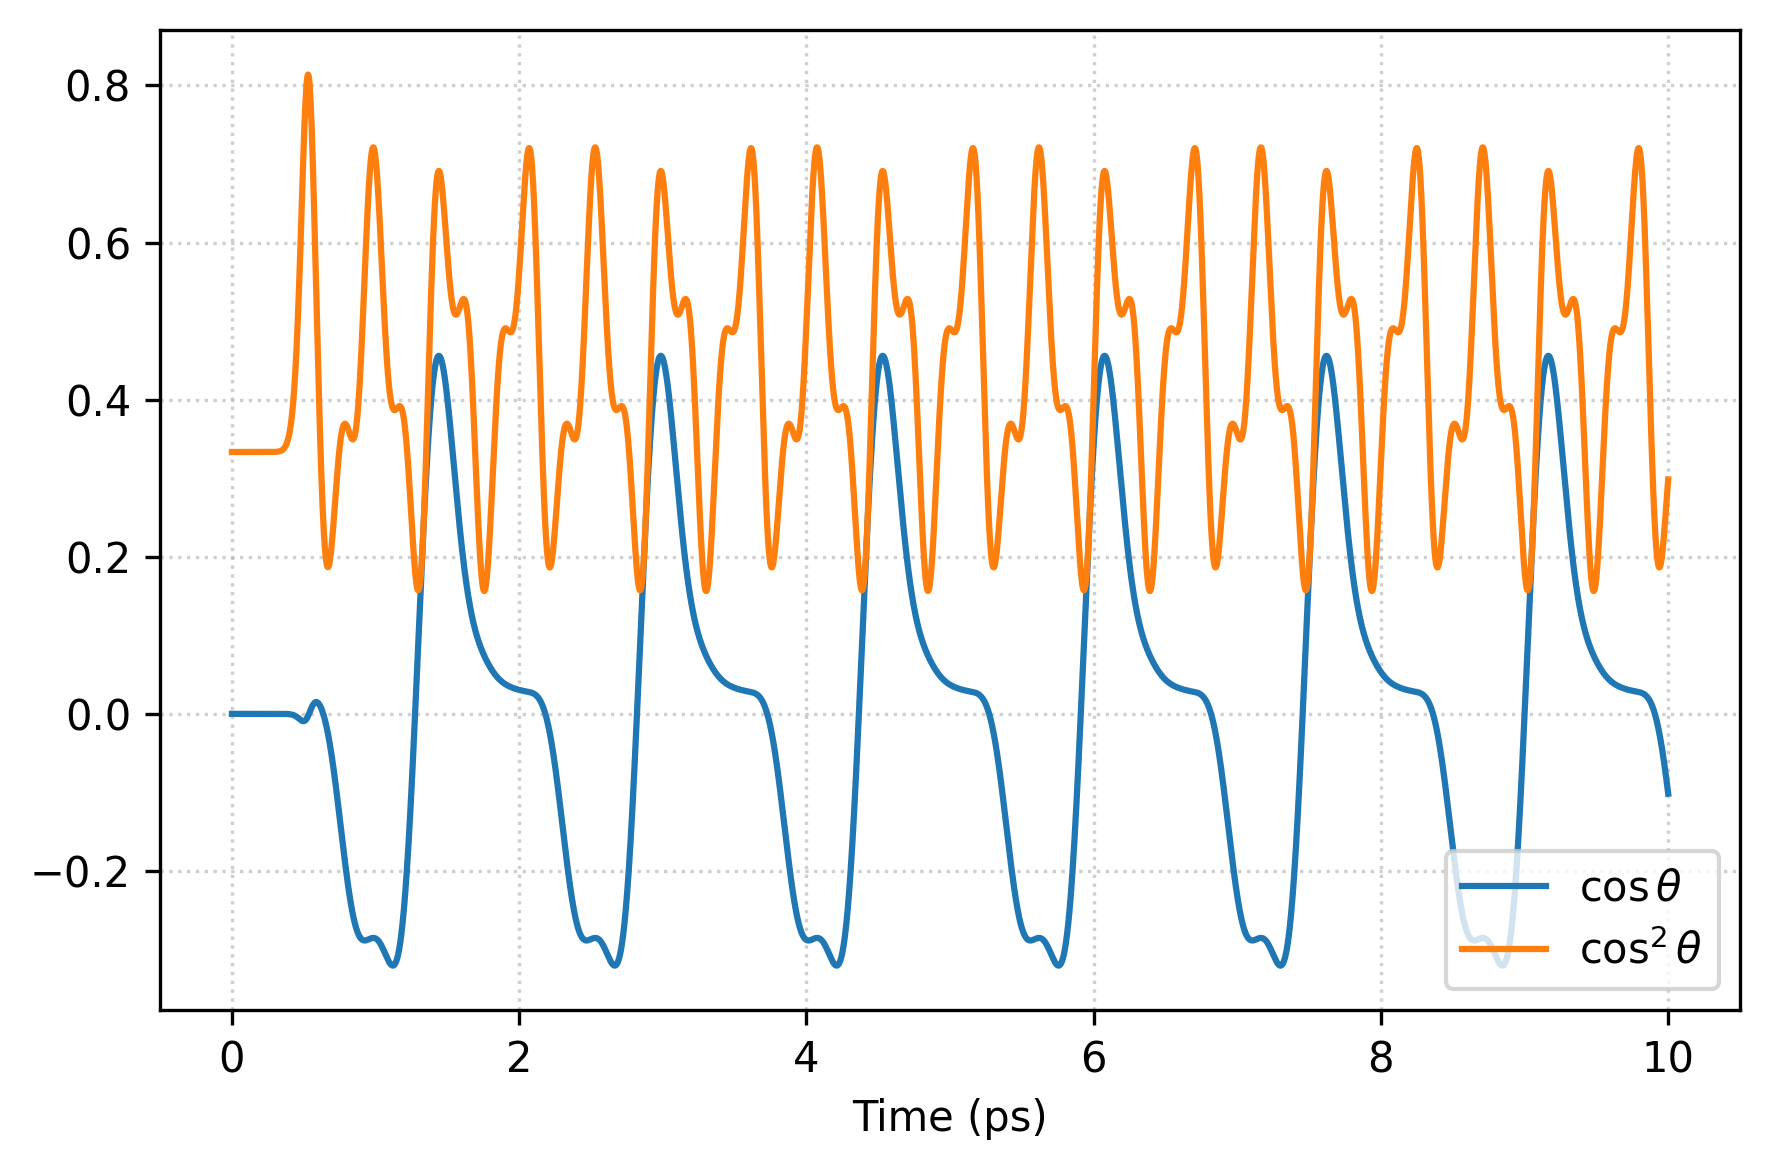

In [11]:
expval_cos_beta = np.einsum(
    "ti,it->t", np.conj(c_t), cos_beta.mat().dot(c_t.T), optimize="optimal"
)
expval_cos2_beta = (
    np.einsum("ti,it->t", np.conj(c_t), cos2_beta.mat().dot(c_t.T), optimize="optimal")
    + 1 / 3
)

plt.figure(figsize=(6, 4), dpi=300)
plt.plot(time, expval_cos_beta, linewidth=1.5, label="$\\cos\\theta$")
plt.plot(time, expval_cos2_beta, linewidth=1.5, label="$\\cos^2\\theta$")
plt.xlabel("Time (ps)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, loc="lower right")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

Compute and plot alignment functions $\cos\beta$, $\cos\beta_{2D}$, $\cos^2\beta$, and $\cos^2\beta_{2D}$, using Monte-Carlo approach.

In [12]:
coefs = c_t[::10]

expval = []
nbatches = 10
for ibatch, c in enumerate(np.split(coefs, nbatches)):
    print(f"batch {ibatch+1}/{nbatches}")
    expval.append(
        states.mc_costheta(
            c.T,
            alpha=np.linspace(0, 2 * np.pi, 100),
            beta=np.linspace(0, np.pi, 100),
            gamma=np.linspace(0, 2 * np.pi, 100),
        )
    )

mc_cos_beta, mc_cos2_beta, mc_cos_beta2d, mc_cos2_beta2d = np.concatenate(
    expval, axis=-1
)

batch 1/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 2/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 3/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 4/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 5/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 6/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 7/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 8/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 9/10
remark: compute reduced rotational density using _rot_dens_wp1
batch 10/10
remark: compute reduced rotational density using _rot_dens_wp1


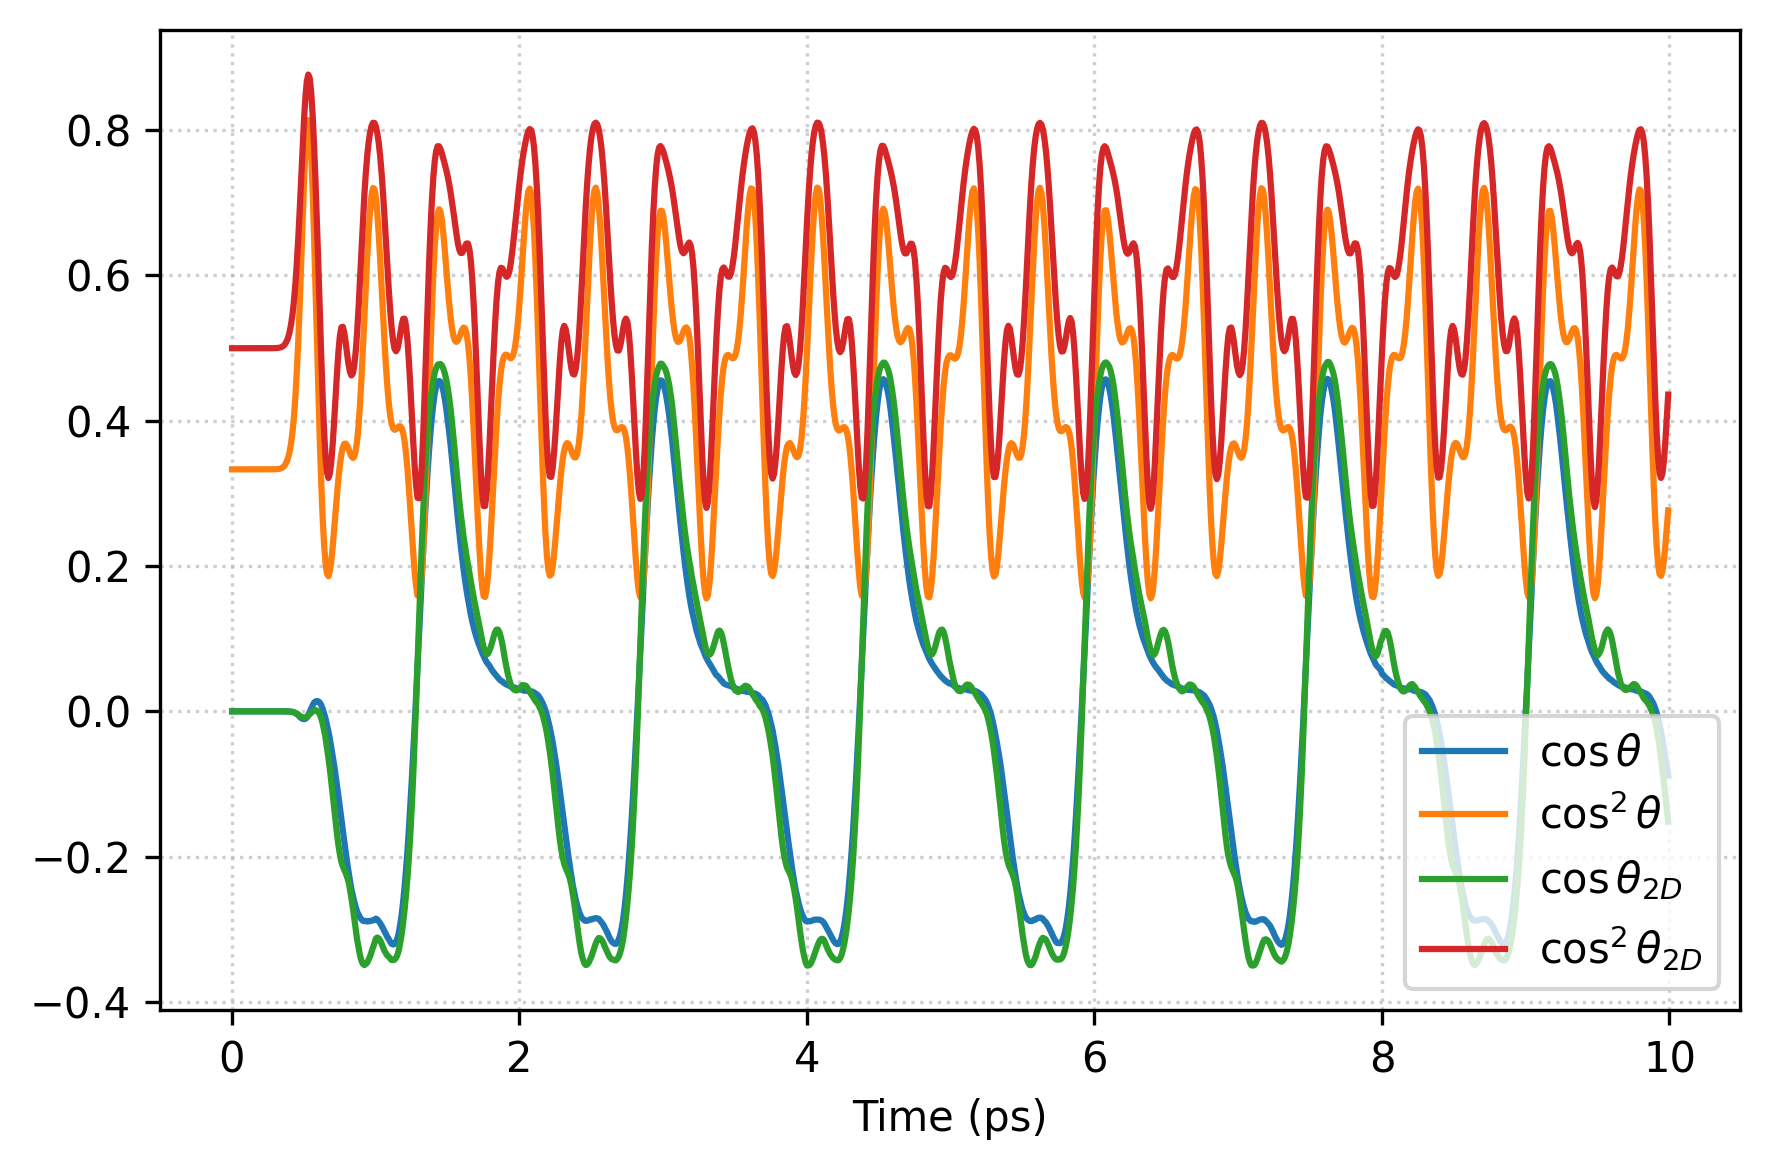

In [13]:
t = time[::10]

plt.figure(figsize=(6, 4), dpi=300)
plt.plot(t, mc_cos_beta, linewidth=1.5, label="$\\cos\\theta$")
plt.plot(t, mc_cos2_beta, linewidth=1.5, label="$\\cos^2\\theta$")
plt.plot(t, mc_cos_beta2d, linewidth=1.5, label="$\\cos\\theta_{2D}$")
plt.plot(t, mc_cos2_beta2d, linewidth=1.5, label="$\\cos^2\\theta_{2D}$")
plt.xlabel("Time (ps)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, loc="lower right")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()